In [ ]:
%load_ext autoreload
%autoreload 2

### Imports

In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.basic2 import Basic2
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

### Initialize Task

In [2]:
experiment = 'interactive'
name = 'basic'

In [3]:
dt = 10
tau = 50
T = 3000
N_batch = 50
N_rec = 100

In [4]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch)

### Set up parameters

In [5]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.1

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [6]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)

### Train Model

In [7]:
trials = 25000
train_params = {}
# train_params['save_weights_path'] =  "./weihts/basic2_w"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [8]:
losses, initialTime, trainTime = model.train(task, train_params)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.085529
Iter 1000, Minibatch Loss= 0.079512
Iter 1500, Minibatch Loss= 0.057741
Iter 2000, Minibatch Loss= 0.040980
Iter 2500, Minibatch Loss= 0.039302
Iter 3000, Minibatch Loss= 0.030047
Iter 3500, Minibatch Loss= 0.027986
Iter 4000, Minibatch Loss= 0.031923
Iter 4500, Minibatch Loss= 0.024612
Iter 5000, Minibatch Loss= 0.023431
Iter 5500, Minibatch Loss= 0.028353
Iter 6000, Minibatch Loss= 0.018438
Iter 6500, Minibatch Loss= 0.021831
Iter 7000, Minibatch Loss= 0.019127
Iter 7500, Minibatch Loss= 0.016199
Iter 8000, Minibatch Loss= 0.016410
Iter 8500, Minibatch Loss= 0.016440
Iter 9000, Minibatch Loss= 0.018569
Iter 9500, Minibatch Loss= 0.018820
Iter 10000, Minibatch Loss= 0.020808
Iter 10500, Minibatch Loss= 0.010989
Iter 11000, Minibatch Loss= 0.014347
Iter 11500, Minibatch Loss= 0.020024
Iter 12000, Minibatch Loss= 0.015782
Iter 12500, Minibatch Loss= 0.015528
I

Text(0.5, 1.0, 'Loss During Training')

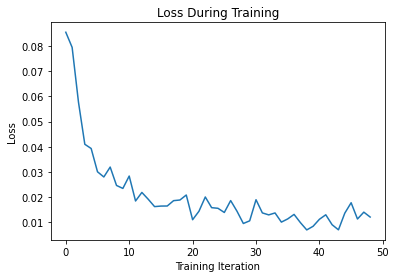

In [9]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

### Test on 10000 trials to examine performance

In [10]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [11]:
for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


In [ ]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10):
    plt.figure()
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 3])

    plt.figure()
    plt.plot(np.arange(0, 3000, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, 3000, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, 3000)

In [12]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


In [14]:
checker_mean

,coherence_bin,trial,coherence,green_side,correct_side,target_onset,checker_onset,decision,green_decision,decision_time,correct_decision
0,-0.9,2597.832168,-0.876072,0.454545,0.545455,382.776224,738.972028,0.545455,0.000000,229.370629,1.000000
1,-0.8,2555.032609,-0.798818,0.536232,0.463768,382.358696,761.239130,0.463768,0.000000,231.402174,1.000000
2,-0.7,2636.117021,-0.699710,0.443262,0.556738,375.333333,740.815603,0.556738,0.000000,259.666667,1.000000
3,-0.6,2522.893130,-0.600857,0.477099,0.522901,381.122137,763.225191,0.522901,0.000000,261.835878,1.000000
4,-0.5,2348.393617,-0.498444,0.567376,0.432624,368.443262,738.446809,0.432624,0.000000,307.542553,1.000000
5,-0.4,2529.161972,-0.400579,0.496479,0.503521,376.419014,735.014085,0.503521,0.000000,333.602113,1.000000
6,-0.3,2492.893333,-0.300932,0.500000,0.500000,372.006667,759.366667,0.500000,0.000000,385.260000,1.000000
7,-0.2,2479.548276,-0.200817,0.503448,0.496552,382.368966,736.082759,0.500000,0.003448,462.410345,0.996552
8,-0.1,2457.114286,-0.099503,0.489796,0.510204,377.714286,737.138776,0.526531,0.016327,865.310204,0.983673
9,0.0,2450.882784,0.000779,0.523810,0.501832,377.073260,736.670330,0.824176,0.567766,1374.571429,0.677656


In [ ]:
plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

# RT within same coherence

In [ ]:
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.figure()
    plt.hist(RT)
    plt.title("Coherence: " + str(i))

In [ ]:
model.destruct()